#pip

In [1]:
!unzip /content/drive/MyDrive/Colab_Notebooks/2023_성균관대_segmentation대회/open.zip #약 10분

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train_img/TRAIN_2140.png  
  inflating: train_img/TRAIN_2141.png  
  inflating: train_img/TRAIN_2142.png  
  inflating: train_img/TRAIN_2143.png  
  inflating: train_img/TRAIN_2144.png  
  inflating: train_img/TRAIN_2145.png  
  inflating: train_img/TRAIN_2146.png  
  inflating: train_img/TRAIN_2147.png  
  inflating: train_img/TRAIN_2148.png  
  inflating: train_img/TRAIN_2149.png  
  inflating: train_img/TRAIN_2150.png  
  inflating: train_img/TRAIN_2151.png  
  inflating: train_img/TRAIN_2152.png  
  inflating: train_img/TRAIN_2153.png  
  inflating: train_img/TRAIN_2154.png  
  inflating: train_img/TRAIN_2155.png  
  inflating: train_img/TRAIN_2156.png  
  inflating: train_img/TRAIN_2157.png  
  inflating: train_img/TRAIN_2158.png  
  inflating: train_img/TRAIN_2159.png  
  inflating: train_img/TRAIN_2160.png  
  inflating: train_img/TRAIN_2161.png  
  inflating: train_img/TRAIN_2162.png  
  inflating: train_img/TRAIN_2163.png  
  in

#metric func

In [1]:
'''
Author: Azhan Mohammed
Email: azhanmohammed1999@gmail.com
Python: 3.7.10
Description: Custom loss functions to train the model
'''

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss(ignore_index=-1)(inputs, targets)

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [2]:
#PyTorch
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

#calculate loss

In [3]:
import numpy as np
import pandas as pd
from typing import List, Union
from joblib import Parallel, delayed


def rle_decode(mask_rle: Union[str, int], shape=(224, 224)) -> np.array:
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    if mask_rle == -1:
        return np.zeros(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7) -> float:
    '''
    Calculate Dice Score between two binary masks.
    '''
    intersection = np.sum(prediction * ground_truth)
    return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)


def calculate_dice_scores(ground_truth_df, prediction_df, img_shape=(224, 224)) -> List[float]:
    '''
    Calculate Dice scores for a dataset.
    '''


    # Keep only the rows in the prediction dataframe that have matching img_ids in the ground truth dataframe
    #prediction_df = prediction_df[prediction_df.iloc[:, 0].isin(ground_truth_df.iloc[:, 0])]
    #prediction_df.index = range(prediction_df.shape[0])


    # Extract the mask_rle columns
    #pred_mask_rle = prediction_df.iloc[:, 1]
    #gt_mask_rle = ground_truth_df.iloc[:, 1]
    pred_mask_rle = prediction_df
    gt_mask_rle = ground_truth_df


    def calculate_dice(pred_rle, gt_rle):
        #pred_mask = rle_decode(pred_rle, img_shape)
        #gt_mask = rle_decode(gt_rle, img_shape)
        pred_mask = pred_rle
        gt_mask = gt_rle

        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None


    dice_scores = Parallel(n_jobs=-1)(
        delayed(calculate_dice)(pred_rle, gt_rle) for pred_rle, gt_rle in zip(pred_mask_rle, gt_mask_rle)
    )


    dice_scores = [score for score in dice_scores if score is not None]  # Exclude None values


    return np.mean(dice_scores)

#model dataset/transform

In [19]:
import os
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import RandomCrop, Compose
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),  # 좌우 대칭
        A.VerticalFlip(p=0.5),    # 상하 대칭
        A.Rotate(limit=180, p=0.5),  # 90도 회전
        A.RandomResizedCrop(224,224,scale=(0.17,0.27),ratio=(1.0,1.0)), #0.22 -> 1024 -> 224
        #A.RandomCrop(224,224),
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)
vali_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),  # 좌우 대칭
        A.VerticalFlip(p=0.5),    # 상하 대칭
        A.RandomCrop(224,224),
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)

test_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)


class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False, is_validation=False, is_test=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer
        self.is_validation = is_validation
        if(is_test):
          pass
        elif(self.is_validation):
          self.data = self.data[:100]
        else:
          self.data = self.data[100:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform: #infer는 test_transform으로
                image = test_transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
          if self.is_validation:
            augmented = vali_transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
          else:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

#model main

In [5]:

import torch
import numpy as np
from torch import nn
import random

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class ResidualBlock(nn.Module):
    def __init__(self, inputChannel, outputChannel, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(inputChannel, outputChannel, stride)
        self.bn1 = nn.BatchNorm2d(outputChannel)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(outputChannel, outputChannel)
        self.bn2 = nn.BatchNorm2d(outputChannel)
        self.downsample = downsample
        self.ca = ChannelAttention(outputChannel)
        self.sa = SpatialAttention()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        caOutput = self.ca(out)
        out = caOutput * out
        saOutput = self.sa(out)
        out = saOutput * out
        return out, saOutput

class BasicDownSample(nn.Module):
    def __init__(self, inputChannel, outputChannel):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(inputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2),
            nn.Conv2d(outputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2)
        )

    def forward(self,x):
        x = self.convolution(x)
        return x

class DownSampleWithAttention(nn.Module):
    def __init__(self, inputChannel, outputChannel):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(inputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2),
            nn.Conv2d(outputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2)
        )
        self.ca = ChannelAttention(outputChannel)
        self.sa = SpatialAttention()

    def forward(self,x):
        x = self.convolution(x)
        caOutput = self.ca(x)
        x = caOutput * x
        saOutput = self.sa(x)
        x = saOutput * x
        return x, saOutput

class BasicUpSample(nn.Module):
    def __init__(self, inputChannel, outputChannel):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(inputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2),
            nn.Conv2d(outputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2)
        )
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.upsample(x)
        x = self.convolution(x)
        return x

class UpSampleWithAttention(nn.Module):
    def __init__(self, inputChannel, outputChannel):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(inputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2),
            nn.Conv2d(outputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2)
        )
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.ca = ChannelAttention(outputChannel)
        self.sa = SpatialAttention()

    def forward(self, x):
        x = self.upsample(x)
        x = self.convolution(x)
        caOutput = self.ca(x)
        x = caOutput * x
        saOutput = self.sa(x)
        x = saOutput * x
        return x, saOutput

class UNet(nn.Module):
  def __init__(self, inputChannel, outputChannel):
    super().__init__()
    self.downsample1 = BasicDownSample(inputChannel, 32)
    self.downsample2 = BasicDownSample(32, 64)
    self.downsample3 = BasicDownSample(64, 128)
    self.downsample4 = BasicDownSample(128, 256)
    self.downsample5 = BasicDownSample(256, 512)

    self.upsample1 = BasicUpSample(512, 256)
    self.upsample2 = BasicUpSample(512, 128)
    self.upsample3 = BasicUpSample(256, 64)
    self.upsample4 = BasicUpSample(128, 32)
    self.upsample5 = BasicUpSample(64, 32)
    self.classification = self.classification = nn.Sequential(
            nn.Conv2d(32, outputChannel, kernel_size=1),
        )

  def forward(self, x):
    scale128 = self.downsample1(x)
    scale64 = self.downsample2(scale128)
    scale32 = self.downsample3(scale64)
    scale16 = self.downsample4(scale32)
    scale8 = self.downsample5(scale16)
    upscale16 = self.upsample1(scale8)
    upscale16 = torch.cat([upscale16, scale16], dim=1)
    upscale32 = self.upsample2(upscale16)
    upscale32 = torch.cat([upscale32, scale32], dim=1)
    upscale64 = self.upsample3(upscale32)
    upscale64 = torch.cat([upscale64, scale64], dim=1)
    upscale128 = self.upsample4(upscale64)
    upscale128 = torch.cat([upscale128, scale128], dim=1)
    upscale256 = self.upsample5(upscale128)
    finaloutput = self.classification(upscale256)
    return finaloutput

class AttentionUNet(nn.Module):
  def __init__(self, inputChannel, outputChannel):
    super().__init__()
    self.downsample1 = DownSampleWithAttention(inputChannel, 32)
    self.downsample2 = DownSampleWithAttention(32, 64)
    self.downsample3 = DownSampleWithAttention(64, 128)
    self.downsample4 = DownSampleWithAttention(128, 256)
    self.downsample5 = DownSampleWithAttention(256, 512)

    self.upsample1 = UpSampleWithAttention(512, 256)
    self.upsample2 = UpSampleWithAttention(512, 128)
    self.upsample3 = UpSampleWithAttention(256, 64)
    self.upsample4 = UpSampleWithAttention(128, 32)
    self.upsample5 = UpSampleWithAttention(64, 32)
    self.classification = nn.Sequential(
            nn.Conv2d(32, outputChannel, kernel_size=1),
        )

  def forward(self, x):
    scale128, sa128down = self.downsample1(x)
    scale64, sa64down = self.downsample2(scale128)
    scale32, sa32down = self.downsample3(scale64)
    scale16, sa64down = self.downsample4(scale32)
    scale8, sa8down = self.downsample5(scale16)
    upscale16, sa16up = self.upsample1(scale8)
    upscale16 = torch.cat([upscale16, scale16], dim=1)
    upscale32, sa32up = self.upsample2(upscale16)
    upscale32 = torch.cat([upscale32, scale32], dim=1)
    upscale64, sa64up = self.upsample3(upscale32)
    upscale64 = torch.cat([upscale64, scale64], dim=1)
    upscale128, sa128up = self.upsample4(upscale64)
    upscale128 = torch.cat([upscale128, scale128], dim=1)
    upscale256, sa256up = self.upsample5(upscale128)
    finaloutput = self.classification(upscale256)
    return finaloutput

class ResidualAttentionUNet(nn.Module):
  def __init__(self, inputChannel, outputChannel):
    super().__init__()
    self.downsample1 = DownSampleWithAttention(inputChannel, 32)
    self.downsample2 = DownSampleWithAttention(32, 64)
    self.downsample3 = DownSampleWithAttention(64, 128)
    self.downsample4 = DownSampleWithAttention(128, 256)
    self.downsample5 = DownSampleWithAttention(256, 512)

    self.residualBlock1 = ResidualBlock(512, 512)
    self.residualBlock2 = ResidualBlock(512, 512)
    self.residualBlock3 = ResidualBlock(512, 512)

    self.upsample1 = UpSampleWithAttention(512, 256)
    self.upsample2 = UpSampleWithAttention(512, 128)
    self.upsample3 = UpSampleWithAttention(256, 64)
    self.upsample4 = UpSampleWithAttention(128, 32)
    self.upsample5 = UpSampleWithAttention(64, 32)
    self.classification = nn.Sequential(
            nn.Conv2d(32, outputChannel, kernel_size=1),
        )

  def forward(self, x):
    scale128, sa128down = self.downsample1(x)
    scale64, sa64down = self.downsample2(scale128)
    scale32, sa32down = self.downsample3(scale64)
    scale16, sa64down = self.downsample4(scale32)
    scale8, sa8down = self.downsample5(scale16)
    scale8, sa8down = self.residualBlock1(scale8)
    scale8, sa8down = self.residualBlock2(scale8)
    scale8, sa8down = self.residualBlock3(scale8)
    upscale16, sa16up = self.upsample1(scale8)
    upscale16 = torch.cat([upscale16, scale16], dim=1)
    upscale32, sa32up = self.upsample2(upscale16)
    upscale32 = torch.cat([upscale32, scale32], dim=1)
    upscale64, sa64up = self.upsample3(upscale32)
    upscale64 = torch.cat([upscale64, scale64], dim=1)
    upscale128, sa128up = self.upsample4(upscale64)
    upscale128 = torch.cat([upscale128, scale128], dim=1)
    upscale256, sa256up = self.upsample5(upscale128)
    finaloutput = self.classification(upscale256)
    return finaloutput

#train/eval method

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

def train():
    # training loop
    for epoch in range(50):  # 10 에폭 동안 학습합니다.
        model.train()
        epoch_loss = 0
        for images, masks in tqdm(dataloader):
            images = images.float().to(device)
            masks = masks.float().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        scheduler.step()
        print("lr: ", optimizer.param_groups[0]['lr'])

        model.eval()
        vali_epoch_loss=0
        dice_score = 0
        for images, masks in tqdm(vali_dataloader):
            images = images.float().to(device)
            masks = masks.float().to(device)

            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))

            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            preds = np.squeeze(preds, axis=1)
            preds = (preds > 0.5).astype(np.uint8) # Threshold = 0.35

            vali_epoch_loss += loss.item()

            masks = masks.detach().cpu().numpy()

            dice_score+=calculate_dice_scores(masks,preds) * len(images)


        print(f'Epoch {epoch+1}, train_Loss: {epoch_loss/len(dataloader)} vali_loss: {vali_epoch_loss/len(vali_dataloader)} dice_score: {dice_score/len(vali_dataset)}')

def vali_inference():
  with torch.no_grad():
     model.eval()
     dice_score=0
     for images, masks in tqdm(vali_dataloader):
            images = images.float().to(device)
            masks = masks.float().to(device)

            outputs = model(images)

            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            preds = np.squeeze(preds, axis=1)
            preds = (preds > 0.5).astype(np.uint8) # Threshold = 0.35

            masks = masks.detach().cpu().numpy()

                        # 네프파이 배열을 이미지로 변환
        #    for i in range(len(images)):
        #      # 이미지를 파일로 저장
        #      cv2.imwrite(f"image_mask_sample_{i}.png",masks[i])
        #
        #      # 이미지를 파일로 저장
        #      cv2.imwrite(f"image_pred_sample_{i}.png",preds[i])  # 저장할 파일 이름과 확장자를 적절히 지정하세요

            dice_score+=calculate_dice_scores(masks,preds) * len(images)
     print(f"dice score for validation: {dice_score/len(vali_dataset)}")

def inference():
    with torch.no_grad():
        model.eval()
        result = []
        for images in tqdm(test_dataloader):
            images = images.float().to(device)

            outputs = model(images)
            masks = torch.sigmoid(outputs).cpu().numpy()
            masks = np.squeeze(masks, axis=1)
            masks = (masks > 0.5).astype(np.uint8) # Threshold = 0.35

            #for i in range(len(masks)):
            #  mask = masks[i]
            #  if(len(mask[mask==1])<1000):
            #    mask[mask==1]=0
            #    masks[i]=mask


            for i in range(len(images)):
                mask_rle = rle_encode(masks[i])
                if len(mask_rle.split()) < 10: # 예측된 건물 픽셀이 아예 없는 경우 -1
                    result.append(-1)
                else:
                    result.append(mask_rle)
        submit = pd.read_csv('./sample_submission.csv')
        submit['mask_rle'] = result
        submit.to_csv(csv_loc, index=False)

#load data

In [7]:
csv_loc = '/content/drive/MyDrive/Colab_Notebooks/2023_성균관대_segmentation대회/residual_attention_20230707.csv'
model_name = '/content/drive/MyDrive/Colab_Notebooks/2023_성균관대_segmentation대회/model/residual_attention_unet_20230707.pt'

In [8]:
model = ResidualAttentionUNet(3,1).to(device) #3= input, 1=output
#model.load_state_dict(torch.load(model_name))

In [20]:

#criterion = FocalLoss()

from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = torch.nn.BCEWithLogitsLoss()
#criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.9 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)

batch_size=32

dataset = SatelliteDataset(csv_file='./train.csv', transform=transform, is_validation=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

vali_dataset = SatelliteDataset(csv_file='./train.csv', transform=transform,is_validation=True)
vali_dataloader = DataLoader(vali_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform, infer=True,is_test=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


print(len(dataset))
print(len(vali_dataset))
print(len(test_dataset))

print()

print(len(dataloader))
print(len(vali_dataloader))
print(len(test_dataloader))

#"checking error"
dataset[1]
vali_dataset[1]
test_dataset[1]
print("dataset finished")

7040
100
60640

220
4
1895
dataset finished


In [10]:
num_params = sum(p.numel() for p in model.parameters())
num_params

21800251

In [11]:
torch.cuda.empty_cache()

In [12]:
train()  # 모델 훈련
#모델 저장
torch.save(model.state_dict(),model_name)

100%|██████████| 220/220 [02:32<00:00,  1.44it/s]


lr:  0.0045000000000000005


100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Epoch 1, train_Loss: 0.18389532606710088 vali_loss: 0.13963907212018967 dice_score: 0.2732090868045553


100%|██████████| 220/220 [02:26<00:00,  1.50it/s]


lr:  0.004050000000000001


100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


Epoch 2, train_Loss: 0.13523466116325422 vali_loss: 0.12769055925309658 dice_score: 0.36840518182925763


100%|██████████| 220/220 [02:24<00:00,  1.52it/s]


lr:  0.0036450000000000007


100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


Epoch 3, train_Loss: 0.12616040286692706 vali_loss: 0.12839097902178764 dice_score: 0.3432310800873685


100%|██████████| 220/220 [02:24<00:00,  1.52it/s]


lr:  0.0032805


100%|██████████| 4/4 [00:02<00:00,  1.35it/s]


Epoch 4, train_Loss: 0.11973635798150843 vali_loss: 0.12628048472106457 dice_score: 0.48167323234256343


100%|██████████| 220/220 [02:25<00:00,  1.51it/s]


lr:  0.0029524500000000006


100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


Epoch 5, train_Loss: 0.11474277024919337 vali_loss: 0.1359581258147955 dice_score: 0.4568218910631897


100%|██████████| 220/220 [02:24<00:00,  1.52it/s]


lr:  0.002657205


100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Epoch 6, train_Loss: 0.10779823163016276 vali_loss: 0.09616554714739323 dice_score: 0.5189993175297728


100%|██████████| 220/220 [02:23<00:00,  1.53it/s]


lr:  0.0023914845000000003


100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


Epoch 7, train_Loss: 0.10116520029577342 vali_loss: 0.11974913999438286 dice_score: 0.5751263599813068


100%|██████████| 220/220 [02:22<00:00,  1.54it/s]


lr:  0.0021523360500000006


100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


Epoch 8, train_Loss: 0.09630932657217438 vali_loss: 0.1104294415563345 dice_score: 0.5150707667856973


100%|██████████| 220/220 [02:23<00:00,  1.53it/s]


lr:  0.0019371024450000004


100%|██████████| 4/4 [00:03<00:00,  1.29it/s]


Epoch 9, train_Loss: 0.09330379309302027 vali_loss: 0.09680083766579628 dice_score: 0.5803021733401992


100%|██████████| 220/220 [02:24<00:00,  1.53it/s]


lr:  0.0017433922005000006


100%|██████████| 4/4 [00:02<00:00,  1.35it/s]


Epoch 10, train_Loss: 0.09111410240558061 vali_loss: 0.08342679962515831 dice_score: 0.6004519160652503


100%|██████████| 220/220 [02:24<00:00,  1.52it/s]


lr:  0.0015690529804500003


100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


Epoch 11, train_Loss: 0.08742152865637433 vali_loss: 0.08483664318919182 dice_score: 0.6399687205320345


100%|██████████| 220/220 [02:23<00:00,  1.53it/s]


lr:  0.0014121476824050007


100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


Epoch 12, train_Loss: 0.08539789981124075 vali_loss: 0.08097435813397169 dice_score: 0.6236131535011521


100%|██████████| 220/220 [02:24<00:00,  1.52it/s]


lr:  0.0012709329141645004


100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Epoch 13, train_Loss: 0.08318860088898376 vali_loss: 0.0742120323702693 dice_score: 0.6523007467738731


100%|██████████| 220/220 [02:25<00:00,  1.51it/s]


lr:  0.0011438396227480504


100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


Epoch 14, train_Loss: 0.08131630693308332 vali_loss: 0.07605195418000221 dice_score: 0.68590222042522


100%|██████████| 220/220 [02:27<00:00,  1.49it/s]


lr:  0.0010294556604732454


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Epoch 15, train_Loss: 0.08009026480669325 vali_loss: 0.07707123272120953 dice_score: 0.5914085948493962


100%|██████████| 220/220 [02:26<00:00,  1.50it/s]


lr:  0.0009265100944259208


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


Epoch 16, train_Loss: 0.0771919996900992 vali_loss: 0.06616714596748352 dice_score: 0.6481888298377466


100%|██████████| 220/220 [02:25<00:00,  1.51it/s]


lr:  0.0008338590849833288


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Epoch 17, train_Loss: 0.0776952885599299 vali_loss: 0.07029337249696255 dice_score: 0.6960899218593671


100%|██████████| 220/220 [02:29<00:00,  1.47it/s]


lr:  0.0007504731764849959


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epoch 18, train_Loss: 0.07563948942856355 vali_loss: 0.07032455317676067 dice_score: 0.6777719475538778


100%|██████████| 220/220 [02:26<00:00,  1.51it/s]


lr:  0.0006754258588364964


100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


Epoch 19, train_Loss: 0.0750886647369374 vali_loss: 0.07287358865141869 dice_score: 0.696287341412081


100%|██████████| 220/220 [02:25<00:00,  1.52it/s]


lr:  0.0006078832729528468


100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


Epoch 20, train_Loss: 0.0736581548709761 vali_loss: 0.0751016903668642 dice_score: 0.6693696424560132


100%|██████████| 220/220 [02:26<00:00,  1.50it/s]


lr:  0.0005470949456575622


100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


Epoch 21, train_Loss: 0.07288024901327762 vali_loss: 0.06688313093036413 dice_score: 0.7266217915988341


100%|██████████| 220/220 [02:27<00:00,  1.49it/s]


lr:  0.0004923854510918059


100%|██████████| 4/4 [00:03<00:00,  1.18it/s]


Epoch 22, train_Loss: 0.07130205241793935 vali_loss: 0.06697818450629711 dice_score: 0.6883100557614044


100%|██████████| 220/220 [02:39<00:00,  1.38it/s]


lr:  0.00044314690598262535


100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


Epoch 23, train_Loss: 0.07199679723178798 vali_loss: 0.07062299642711878 dice_score: 0.69346293193236


100%|██████████| 220/220 [02:28<00:00,  1.48it/s]


lr:  0.0003988322153843628


100%|██████████| 4/4 [00:03<00:00,  1.29it/s]


Epoch 24, train_Loss: 0.07072001695632935 vali_loss: 0.0604776325635612 dice_score: 0.6961580864022296


100%|██████████| 220/220 [02:26<00:00,  1.51it/s]


lr:  0.0003589489938459265


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Epoch 25, train_Loss: 0.07011258331212131 vali_loss: 0.0682081924751401 dice_score: 0.6957292142560408


100%|██████████| 220/220 [02:27<00:00,  1.50it/s]


lr:  0.00032305409446133386


100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


Epoch 26, train_Loss: 0.06929239100691947 vali_loss: 0.06417031306773424 dice_score: 0.6903035837968055


100%|██████████| 220/220 [02:26<00:00,  1.50it/s]


lr:  0.0002907486850152005


100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


Epoch 27, train_Loss: 0.06731162182986736 vali_loss: 0.06115529127418995 dice_score: 0.7435931079450032


100%|██████████| 220/220 [02:27<00:00,  1.49it/s]


lr:  0.0002616738165136805


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Epoch 28, train_Loss: 0.06768624718216333 vali_loss: 0.059823052957654 dice_score: 0.7031743963864661


100%|██████████| 220/220 [02:25<00:00,  1.51it/s]


lr:  0.00023550643486231244


100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


Epoch 29, train_Loss: 0.06746198868548328 vali_loss: 0.06279198732227087 dice_score: 0.7124245234337657


100%|██████████| 220/220 [02:28<00:00,  1.48it/s]


lr:  0.0002119557913760812


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epoch 30, train_Loss: 0.0669956962493333 vali_loss: 0.06020079646259546 dice_score: 0.6992393535895696


100%|██████████| 220/220 [02:29<00:00,  1.47it/s]


lr:  0.00019076021223847308


100%|██████████| 4/4 [00:02<00:00,  1.33it/s]


Epoch 31, train_Loss: 0.06735465303063393 vali_loss: 0.06856025755405426 dice_score: 0.7062761032430549


100%|██████████| 220/220 [02:30<00:00,  1.46it/s]


lr:  0.00017168419101462577


100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


Epoch 32, train_Loss: 0.06578119068660519 vali_loss: 0.06196018308401108 dice_score: 0.704191528186975


100%|██████████| 220/220 [02:31<00:00,  1.45it/s]


lr:  0.00015451577191316317


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Epoch 33, train_Loss: 0.06596969616684047 vali_loss: 0.05750217754393816 dice_score: 0.7309970721564499


100%|██████████| 220/220 [02:30<00:00,  1.46it/s]


lr:  0.00013906419472184688


100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


Epoch 34, train_Loss: 0.06613980675624176 vali_loss: 0.06666272599250078 dice_score: 0.7096740122116744


100%|██████████| 220/220 [02:27<00:00,  1.49it/s]


lr:  0.0001251577752496622


100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Epoch 35, train_Loss: 0.0653343111445958 vali_loss: 0.05668456759303808 dice_score: 0.7142181858082346


100%|██████████| 220/220 [02:27<00:00,  1.49it/s]


lr:  0.00011264199772469597


100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


Epoch 36, train_Loss: 0.06504083863374861 vali_loss: 0.06408591754734516 dice_score: 0.7198412843577962


100%|██████████| 220/220 [02:26<00:00,  1.51it/s]


lr:  0.00010137779795222638


100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


Epoch 37, train_Loss: 0.06499459484422748 vali_loss: 0.0574205107986927 dice_score: 0.6747796952267718


100%|██████████| 220/220 [02:25<00:00,  1.52it/s]


lr:  9.124001815700375e-05


100%|██████████| 4/4 [00:03<00:00,  1.29it/s]


Epoch 38, train_Loss: 0.06534757160327652 vali_loss: 0.06332520674914122 dice_score: 0.7279960797200338


100%|██████████| 220/220 [02:25<00:00,  1.51it/s]


lr:  8.211601634130338e-05


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


Epoch 39, train_Loss: 0.06437788189134815 vali_loss: 0.059630343690514565 dice_score: 0.6722990961378018


100%|██████████| 220/220 [02:25<00:00,  1.51it/s]


lr:  7.390441470717304e-05


100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


Epoch 40, train_Loss: 0.06425256197425452 vali_loss: 0.05667639710009098 dice_score: 0.6838439945677564


  0%|          | 0/220 [00:01<?, ?it/s]


KeyboardInterrupt: ignored

In [21]:
vali_inference()

100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

dice score for validation: 0.5156670180739185


In [22]:
inference()

100%|██████████| 1895/1895 [06:09<00:00,  5.13it/s]


In [13]:
torch.save(model.state_dict(),model_name)

#dataset for checking data

In [24]:
#crop 결과 시각화를 위한 dataset
%cd /content/
class plt_Dataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = A.Compose(
          [
              A.HorizontalFlip(p=0.5),  # 좌우 대칭
              A.VerticalFlip(p=0.5),    # 상하 대칭
              #A.Rotate(limit=180, p=0.5),  # 90도 회전
              A.RandomCrop(224,224),
              A.Resize(224, 224),
              ToTensorV2()
          ]
        )
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

plt_dataset = plt_Dataset(csv_file='./train.csv')

#crop 결과 시각화를 위한 dataset
class plt_test_Dataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = A.Compose(
          [

              A.RandomCrop(224,224),
              A.Resize(224, 224),
              ToTensorV2()
          ]
        )
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

plt_test_dataset = plt_test_Dataset(csv_file='./test.csv',infer=True)

/content


#see data

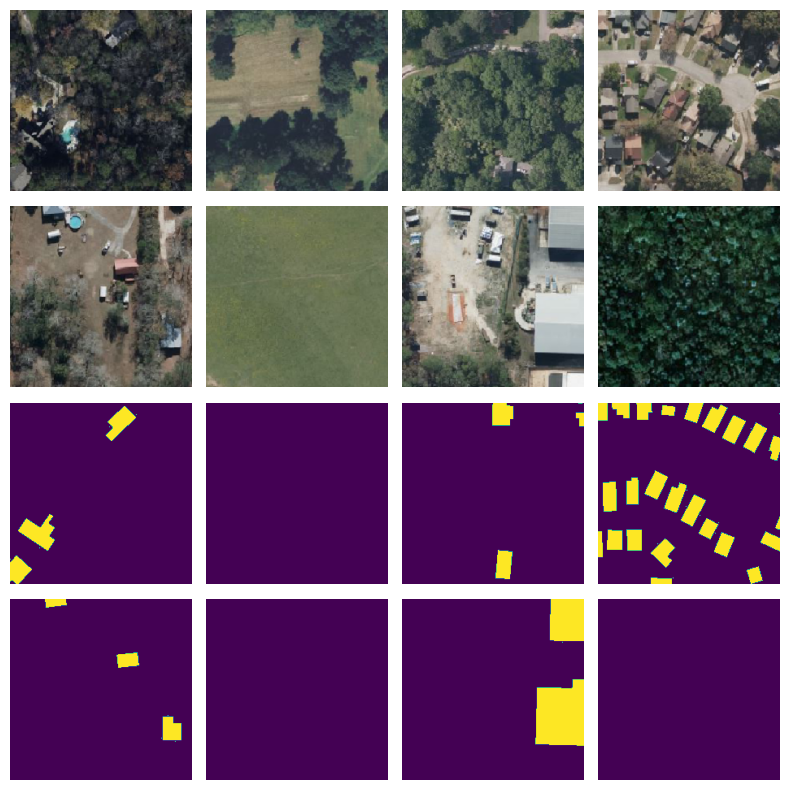

In [25]:
import matplotlib.pyplot as plt
import numpy as np

idx = 6400
image_see = []
mask_see = []
for i in range(idx,idx+8):
  image, mask = plt_dataset[i]
  image_see.append(image)
  mask_see.append(mask)

image_see = np.stack(image_see, axis=0)
mask_see = np.stack(mask_see, axis=0)

def plot_normalized_images(images, masks):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.flatten()

    for i in range(len(images)):
        image = np.transpose(images[i], (1, 2, 0))
        axes[i].imshow(image)
        axes[i].axis('off')

    for i in range(len(masks)):
        axes[i+len(images)].imshow(masks[i])
        axes[i+len(images)].axis('off')

# 이미지 시각화
plot_normalized_images(image_see, mask_see)

plt.tight_layout()
plt.show()



4818
1197
0
7578
6312
7764
3748
0


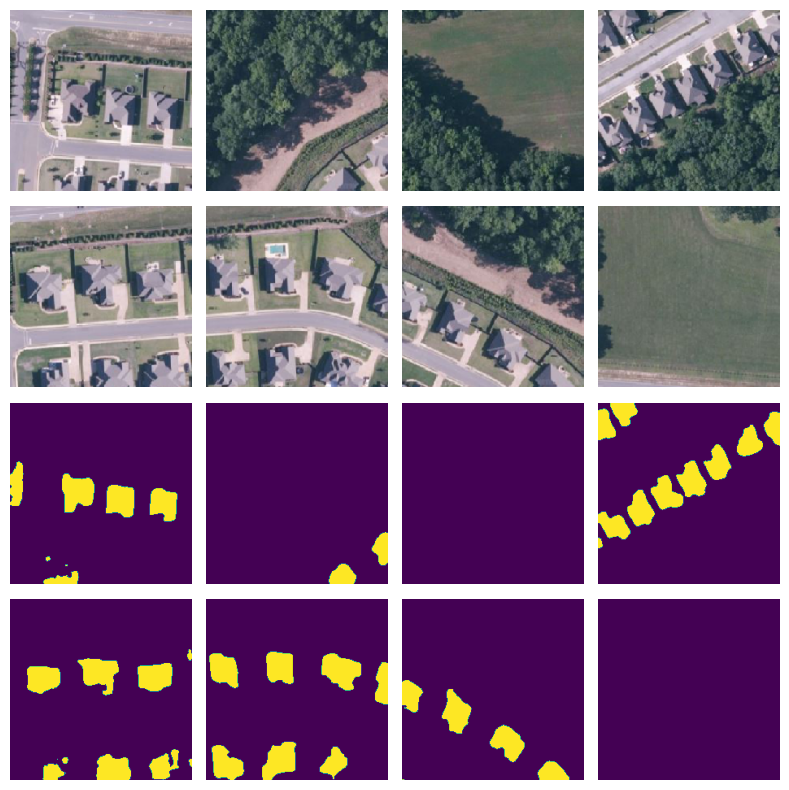

In [26]:
comp_loc = '/content/drive/MyDrive/Colab_Notebooks/2023_성균관대_segmentation대회/submit_64percent.csv'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

idx = 0

image_see = []
mask_see = []

submit_csv = pd.read_csv(comp_loc)
new_submit_csv = submit_csv.copy()

for i in range(idx,idx+8):
  image = plt_test_dataset[i]
  image_see.append(image)

  mask = submit_csv['mask_rle'][i]
  mask = rle_decode(mask,(224,224))
  print(len(mask[mask==1]))

  #if(len(mask[mask==1])<1000):
  #  mask[mask==1]=0
  #  new_mask = rle_encode(mask)
  #  new_submit_csv['mask_rle'][i] = -1

  mask_see.append(mask)

image_see = np.stack(image_see, axis=0)
mask_see = np.stack(mask_see, axis=0)

def plot_normalized_images(images, masks):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.flatten()

    for i in range(len(images)):
        image = np.transpose(images[i], (1, 2, 0))
        axes[i].imshow(image)
        axes[i].axis('off')

    for i in range(len(masks)):
        axes[i+len(images)].imshow(masks[i])
        axes[i+len(images)].axis('off')

# 이미지 시각화
plot_normalized_images(image_see, mask_see)

plt.tight_layout()
plt.show()



3184
511
0
5985
3013
3933
2017
0


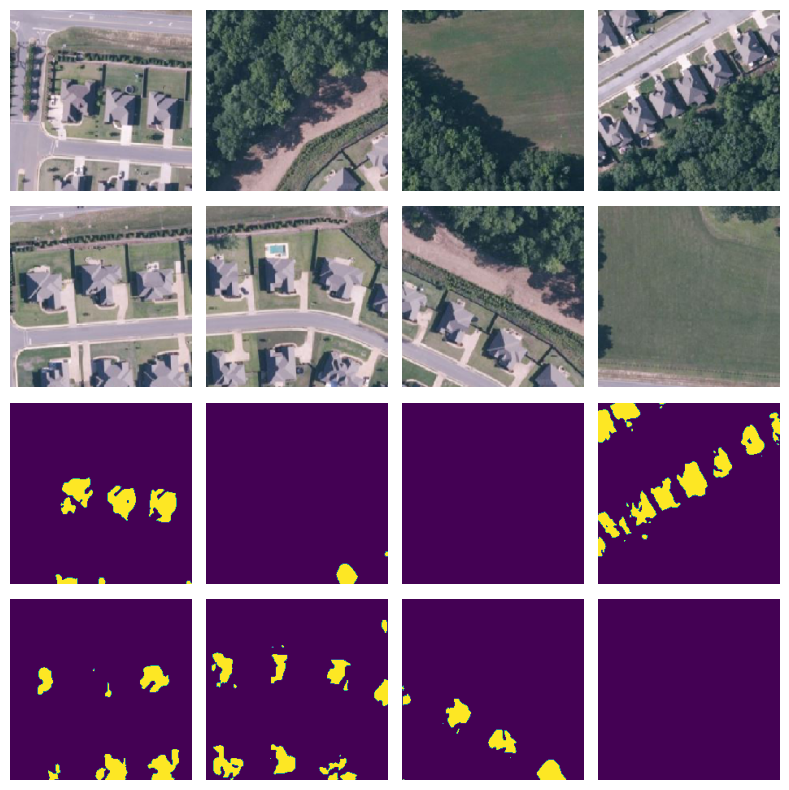

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

idx = 0

image_see = []
mask_see = []

submit_csv = pd.read_csv(csv_loc)
new_submit_csv = submit_csv.copy()

for i in range(idx,idx+8):
  image = plt_test_dataset[i]
  image_see.append(image)

  mask = submit_csv['mask_rle'][i]
  mask = rle_decode(mask,(224,224))
  print(len(mask[mask==1]))

  #if(len(mask[mask==1])<1000):
  #  mask[mask==1]=0
  #  new_mask = rle_encode(mask)
  #  new_submit_csv['mask_rle'][i] = -1

  mask_see.append(mask)

image_see = np.stack(image_see, axis=0)
mask_see = np.stack(mask_see, axis=0)

def plot_normalized_images(images, masks):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.flatten()

    for i in range(len(images)):
        image = np.transpose(images[i], (1, 2, 0))
        axes[i].imshow(image)
        axes[i].axis('off')

    for i in range(len(masks)):
        axes[i+len(images)].imshow(masks[i])
        axes[i+len(images)].axis('off')

# 이미지 시각화
plot_normalized_images(image_see, mask_see)

plt.tight_layout()
plt.show()



#동시비교

2742
1131
7788
3322

32
3585
7724
3850


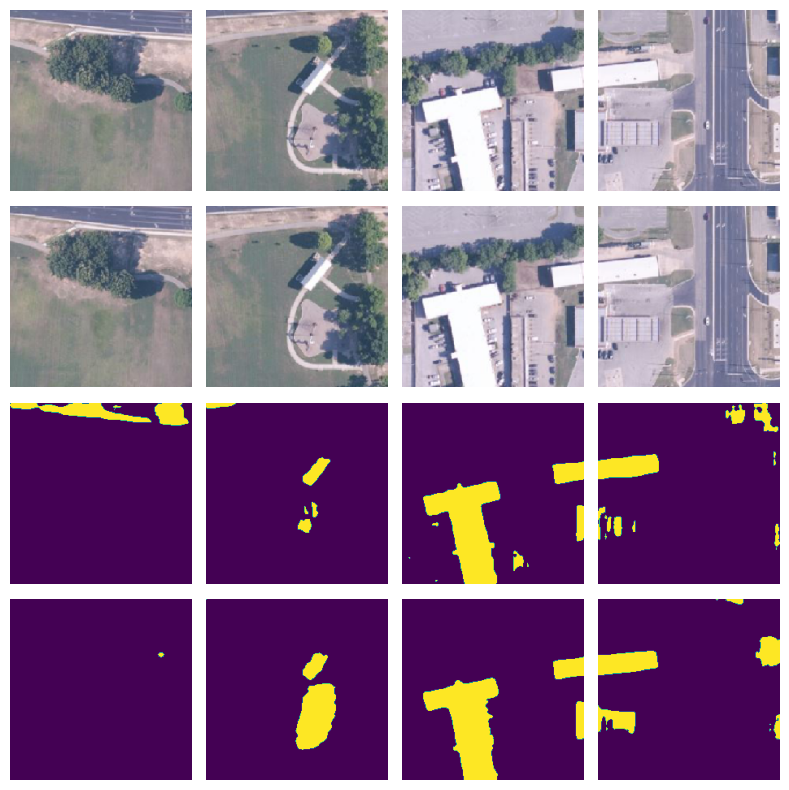

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

comp_loc = '/content/drive/MyDrive/Colab_Notebooks/2023_성균관대_segmentation대회/submit_64percent.csv'
idx = 10930

image_see = []
mask_see = []

submit_csv = pd.read_csv(csv_loc)
comp_csv = pd.read_csv(comp_loc)

new_submit_csv = submit_csv.copy()
new_comp_csv = comp_csv.copy()

for i in range(idx,idx+4):
  image = plt_test_dataset[i]
  image_see.append(image)

  mask = submit_csv['mask_rle'][i]
  mask = rle_decode(mask,(224,224))
  print(len(mask[mask==1]))

  #if(len(mask[mask==1])<1000):
  #  mask[mask==1]=0
  #  new_mask = rle_encode(mask)
  #  new_submit_csv['mask_rle'][i] = -1

  mask_see.append(mask)

print()

for i in range(idx,idx+4):
  image = plt_test_dataset[i]
  image_see.append(image)

  mask = comp_csv['mask_rle'][i]
  mask = rle_decode(mask,(224,224))
  print(len(mask[mask==1]))

  #if(len(mask[mask==1])<1000):
  #  mask[mask==1]=0
  #  new_mask = rle_encode(mask)
  #  new_submit_csv['mask_rle'][i] = -1

  mask_see.append(mask)


image_see = np.stack(image_see, axis=0)
mask_see = np.stack(mask_see, axis=0)

def plot_normalized_images(images, masks):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.flatten()

    for i in range(len(images)):
        image = np.transpose(images[i], (1, 2, 0))
        axes[i].imshow(image)
        axes[i].axis('off')

    for i in range(len(masks)):
        axes[i+len(images)].imshow(masks[i])
        axes[i+len(images)].axis('off')

# 이미지 시각화
plot_normalized_images(image_see, mask_see)

plt.tight_layout()
plt.show()

